#CE4145 Coursework

### Section 1 – Dataset  



The SMS Spam Collection has 5,574 actual texts tagged either 'ham' or 'spam', with spam ones typically pushing prizes, loans, or quick money asks. On the flip side, ham refers to everyday chats between people. These messages were pulled from public websites and contributions by users, so they reflect how people really text each other. Since texts tend to be brief, casual, and full of typos, shorthand, or made-up words, handling them can be tricky. Because of this messiness, the collection works well for testing classifiers meant for chaotic real-life language.

So just using the words in the messages this data works for a yes or no job spotting spam. Since real messages (ham) show up way more often, judging results by accuracy isn't enough. The texts are brief, meaning less context, making cleaning steps and smart encoding key. Even though it’s small, testing runs fast while still showing how various models behave differently.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/datasets/SMSSpamCollection",#change to whereever the dataset is in drive, would've linked to dataset itself but it wouldnt work for me
    sep="\t",
    header=None,
    names=["label", "text"]
)

df["target"] = df["label"].map({"ham": 0, "spam": 1})

x = df["text"].tolist()
y = df["target"].values

print(df.head())
print(df["label"].value_counts())

  label                                               text  target
0   ham  Go until jurong point, crazy.. Available only ...       0
1   ham                      Ok lar... Joking wif u oni...       0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...       1
3   ham  U dun say so early hor... U c already then say...       0
4   ham  Nah I don't think he goes to usf, he lives aro...       0
label
ham     4825
spam     747
Name: count, dtype: int64


### Section 2 – Representation Learning  


The conversion of SMS texts into readable format, followed by number codes, must happen before using any learning algorithm. As both systems rely on the same processing chain, they go through splitting text, turning letters small, removing filler words, or applying root extraction. This process brings consistency while cutting down distractions which is especially useful since messages tend to be brief and full of casual slang. Root reduction combines similar word versions under one base form, shrinking the dictionary load while helping models work better across new data.

Once cleaned up, the text moves to Word2Vec for turning words into number patterns based on how they show up across messages. Instead of treating each word alone, it figures out meanings by looking at nearby words, so related ones end up near each other in this number space. I went with Skip-gram since it handles rare terms better with those often popping up in junk texts. For every line in a message, we take the average of all word vectors inside it. That gives us one steady-sized set of numbers that machines can use to tell spam apart.

In [3]:
#preprocessing
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

def preprocess_text(X):
    processed = []
    sw = set(stopwords.words("english"))
    stemmer = SnowballStemmer("english")

    for text in X:
        tokens = word_tokenize(text)
        tokens = [t.lower() for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if t not in sw]
        tokens = [stemmer.stem(t) for t in tokens]
        processed.append(tokens)

    return processed

prep_x = preprocess_text(x)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
!pip install gensim #needed to pip install because it doesn't come standard on colab anymorre

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 54.8 MB/s eta 0:00:00


In [5]:
#Word2Vec
from gensim.models import Word2Vec
import numpy as np

def sentence_embedding(sentence, w2v_model):
    valid = [w for w in sentence if w in w2v_model.wv.index_to_key]
    if len(valid) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[valid], axis=0)

### Section 3 - Algorithms

This part looks at two totally different machine learning methods - Logistic Regression versus Random Forest. While both use number-based data from earlier pipeline steps, they classify stuff in their own unique styles. Because of this difference they work well for testing how straight-line vs curved decision lines handle spotting spam texts.

Logistic Regression’s a straightforward way to sort data by linking inputs to the chance of falling into one group. Even though it works in a straight-line fashion, it does well on texts since it spots how much each piece matters for the result. It adds up all the input values (each multiplied by a weight) and runs that total through a smooth S-shaped curve to get a likelihood. While learning it tweaks those weights by chasing down mistakes, usually guided by a penalty called cross-entropy. Which is a positive as you can actually make sense of the results, the weights show whether something pushes toward spam or not. Faster to run, this method handles training well while giving solid results especially if data splits clearly along straight lines. That’s why it works great as a starting point before trying fancier options.

Random Forest works by combining many decision trees each built differently. Instead of using all the data every tree gets a random chunk picked with repeats allowed. When splitting nodes only some features are chosen at random each time. These twin layers of chance (one in data selection and one in traits used) help keep the trees from acting alike. A lone tree might memorise noise but lots of varied ones smooth out errors. Because these trees don’t follow straight lines they handle messy twisted relationships between inputs. By design they adapt to how variables mix without needing fixed assumptions. In SMS spam spotting this really helps as spam often mixes odd phrases, weird styles or shifting language forms that don't split neatly with one straight rule. Instead of relying on a single cutoff this method uses layered choices to handle diverse message traits across various data zones.

The difference between these two models helps clarify what the classification job really involves. While Logistic Regression gives a clear, simple and fast approach which would be ideal if feature patterns followed a straightline trend. The Random Forest takes a looser path, capturing curved or complex links in data. Instead of relying on one rule based guess, it combines many decision trees each slightly different. This setup handles messy inputs better especially when texts vary widely in tone or format. Because it averages out errors across multiple models it’s less likely to get tricked by random quirks in messages.


In [6]:
#Algorithms


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

logreg_scores = []
rf_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

prep_arr = np.array(prep_x, dtype=object)

for train_idx, test_idx in kf.split(prep_arr, y):

    X_train_fold = prep_arr[train_idx]
    X_test_fold = prep_arr[test_idx]
    y_train_fold = y[train_idx]
    y_test_fold = y[test_idx]

    # train Word2Vec per fold
    w2v_model = Word2Vec(
        sentences=X_train_fold,
        vector_size=300,
        window=5,
        min_count=2,
        workers=4
    )

    X_train_emb = [sentence_embedding(s, w2v_model) for s in X_train_fold]
    X_test_emb = [sentence_embedding(s, w2v_model) for s in X_test_fold]

    # Pipeline A – Logistic Regression
    logreg = LogisticRegression(
        solver="liblinear",
        max_iter=1000
    )
    logreg.fit(X_train_emb, y_train_fold)
    logreg_pred = logreg.predict(X_test_emb)
    logreg_scores.append(accuracy_score(y_test_fold, logreg_pred))

    # Pipeline B – Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_emb, y_train_fold)
    rf_pred = rf.predict(X_test_emb)
    rf_scores.append(accuracy_score(y_test_fold, rf_pred))

print("Logistic Regression Accuracy:", np.mean(logreg_scores))
print("Random Forest Accuracy:", np.mean(rf_scores))

Logistic Regression Accuracy: 0.8659369943080726
Random Forest Accuracy: 0.9529796877893262


### Section 4 – Evaluation  



The models were tested with 5-part split checks to keep things fair between spam and real messages. Since there were more normal messages than spam ones a balanced method made sense here instead. Testing like this helps when one group is bigger than the other at start. Accuracy scores were averaged in the end as the main way to compare results.

The results show that Logistic Regression has got a high accuracy of around 0.87 and a low amount of inconsistency but it still falls short of its counterpart. This is because the Random Forest Algorithm amassed an extremely high accuracy of 0.95 with slightly more inconsistency in its results but not to a high enough degree to effect its score drastically. These results point to Logistic Regression's linear decision boundary not holding up as well as the Random Forest because of non linear structure of the data.

Overall this evaluation shows that Random Forest is considerably more effective than Logistic Regression in the task of SMS spam detection.

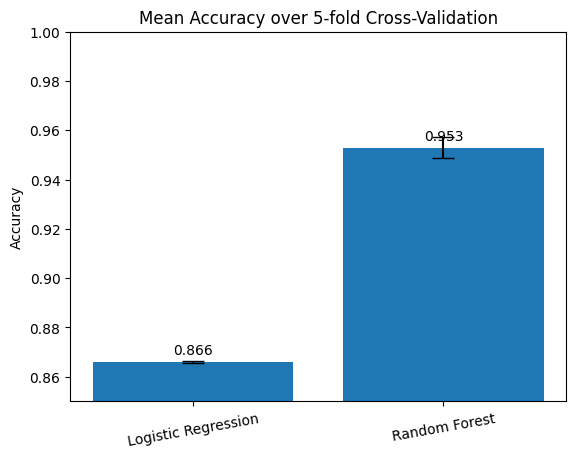

In [7]:
#Evaluation/bar graph
#Used a bar graph as boxplot didnt look great with the consistancy of Log Reg
import matplotlib as plt

# The means and standard deviations of the algorithm scores
means = [np.mean(logreg_scores), np.mean(rf_scores)]
stds  = [np.std(logreg_scores),  np.std(rf_scores)]

labels = ["Logistic Regression", "Random Forest"]

fig, ax = plt.pyplot.subplots()
x = np.arange(len(labels))

ax.bar(x, means, yerr=stds, capsize=8)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=10)
ax.set_ylabel("Accuracy")
ax.set_title("Mean Accuracy over 5-fold Cross-Validation")
ax.set_ylim(0.85, 1.0)   # tighten y-axis so differences are actually noticable

for i, v in enumerate(means):
    ax.text(i, v + 0.003, f"{v:.3f}", ha="center")

plt.pyplot.show()